## 1D Case - Figure 9
 
Comparison of the displacement and strain solutions computed with r-adapted mesh with the analytical reference. Both the trapezoidal rule and the Gauss quadrature are shown and for each, the trajectory maps of the mesh nodes are shown.

In [1]:
#%% Libraries import
# import HiDeNN library
import sys  

from HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
# Import pre-processing functions
import Bin.Pre_processing as pre
# Import torch librairies
import torch
import torch.nn as nn

# Import Training funcitons
from Bin.Training import Training_1D_FEM_LBFGS
#Import post processing libraries
import Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
mps_device = torch.device("mps")
from importlib import reload  # Python 3.4+
import tomllib
import numpy as numpy
import argparse



In [2]:
# Load default configuration file (defines dimension, domain, boundary conditions, number of training iterations etc.)
Default_config_file = 'Configuration/config_1D.toml'


with open(Default_config_file, mode="rb") as f:
    config = tomllib.load(f)

* Executing job in Configuration/config_1D.toml


 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Dofs:           14
Trapezoidal

epoch =  1
     loss =  -0.02134719793285412
     loss_decrease =  1.0213471979328541
epoch =  2
     loss =  -0.02555727475284785
     loss_decrease =  0.19721917758181604
epoch =  3
     loss =  -0.02555732991921513
     loss_decrease =  2.1585387257974903e-06
epoch =  4
     loss =  -0.025557330481908825
     loss_decrease =  2.2016920214346176e-08
epoch =  5
     loss =  -0.025557330653051328
     loss_decrease =  6.696415459677505e-09
epoch =  6
     loss =  -0.025557330669466215
     loss_decrease =  6.422770450388498e-10
epoch =  7
     loss =  -0.025557330685881112
     loss_decrease =  6

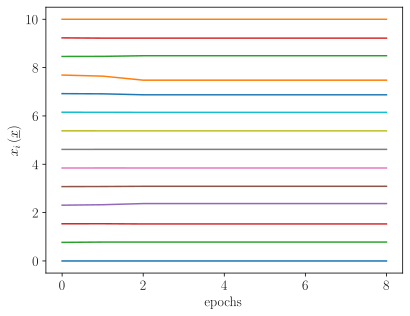

* Final l2 loss : 8.9346e-02
* Final l2 loss grad : 4.3339e-01


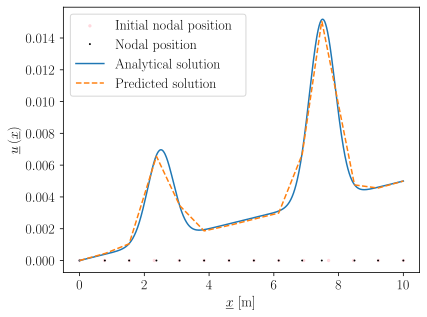

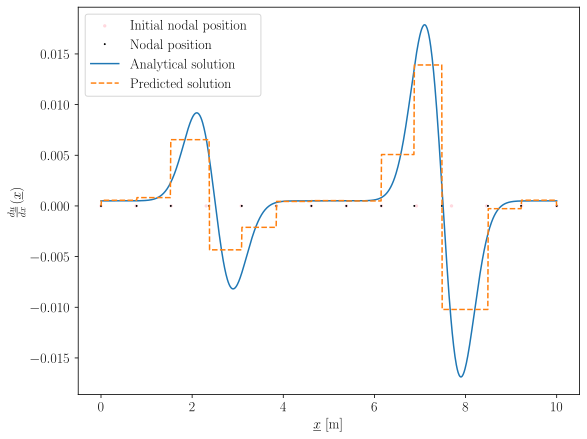

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Dofs:           14
Gaussian_quad


mesh.NNodes =  14
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.020938372050504337
     loss_decrease =  1.0209383720505043
epoch =  2
     loss =  -0.027092758866843328
     loss_decrease =  0.2939286206919201
epoch =  3
     loss =  -0.027259539467172467
     loss_decrease =  0.00615591

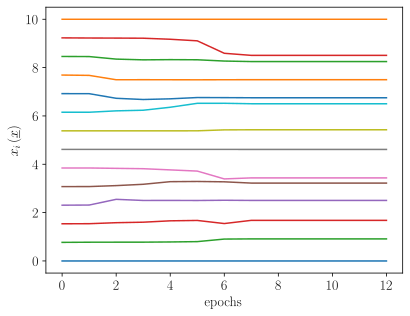


* Final l2 loss : 5.9848e-02
* Final l2 loss grad : 3.4048e-01


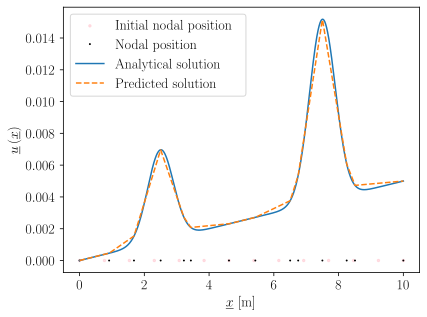

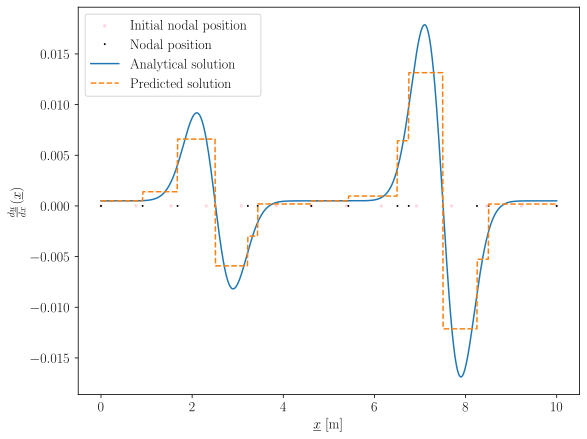

<Figure size 640x480 with 0 Axes>

In [3]:
# Experiment setting: mesh with 14 nodes, Trapezoidal rule and Gauss quadrature, r-adaptive mesh

mesh_resolution = 14
quadrature_points = 5
training_points = 30

integration_method = ["Trapezoidal", "Gaussian_quad"]

config["interpolation"]["np"] = mesh_resolution
config["postprocess"]["Show_Trajectories"] = "True"
config["solver"]["FrozenMesh"] = False


for m in range(len(integration_method)):

    config["solver"]["IntegralMethod"] = integration_method[m]
    if config["solver"]["IntegralMethod"] == "Gaussian_quad":
        config["interpolation"]["n_integr_points"] = quadrature_points
    elif config["solver"]["IntegralMethod"] == "Trapezoidal":
        config["training"]["Points_per_element"] = training_points


    # Load parameters
    if config["interpolation"]["dimension"] == 1:
        Mat = pre.Material(             flag_lame = True,                               # If True should input lmbda and mu instead of E and nu
                                        coef1     = config["material"]["E"],            # Young Modulus
                                        coef2     = config["geometry"]["A"]             # Section area of the 1D bar
                            )
    elif config["interpolation"]["dimension"] == 2:
        try:
            Mat = pre.Material(         flag_lame = False,                              # If True should input lmbda and mu instead of E and nu
                                        coef1     = config["material"]["E"],            # Young Modulus
                                        coef2     = config["material"]["nu"]            # Poisson's ratio
                            )
        except:
            Mat = pre.Material(         flag_lame = True,                               # If True should input lmbda and mu instead of E and nu
                                        coef1     = config["material"]["lmbda"],        # First Lame's coef
                                        coef2     = config["material"]["mu"]            # Second Lame's coef
                            )

    MaxElemSize = pre.ElementSize(
                                    dimension     = config["interpolation"]["dimension"],
                                    L             = config["geometry"]["L"],
                                    order         = config["interpolation"]["order"],
                                    np            = config["interpolation"]["np"],
                                )

    Excluded = []

    Mesh_object = pre.Mesh( 
                                    config["geometry"]["Name"],                 # Create the mesh object
                                    MaxElemSize, 
                                    config["interpolation"]["order"], 
                                    config["interpolation"]["dimension"]
                            )

    Mesh_object.AddBorders(config["Borders"]["Borders"])
    Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                    config["geometry"]["Volume_element"],
                                    Excluded,
                                    config["DirichletDictionryList"]
                        )                   

    Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
    Mesh_object.ReadMesh() 

    print(config["solver"]["IntegralMethod"])
    print()
    # Vtk file not necessary if not using reference element implementation
    if config["solver"]["IntegralMethod"] == "Gaussian_quad":
        Mesh_object.ExportMeshVtk1D()

    # Build the assembly weight matrix if needed
    if config["interpolation"]["dimension"] ==1 and config["solver"]["IntegralMethod"] == "Trapezoidal":
        Mesh_object.AssemblyMatrix()                                            

    if int(Mesh_object.dim) != int(Mesh_object.dimension):
        raise ValueError("The dimension of the provided geometry does not match the job dimension")

    if config["solver"]["TrainingStrategy"]=="Integral":
        match config["solver"]["IntegralMethod"]:                          
            case "Gaussian_quad":
                Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
            case "Trapezoidal":
                Model_FEM = MeshNN(Mesh_object)

    if config["solver"]["TrainingStrategy"]=="Mixed":
        if config["solver"]["IntegralMethod"] == "Gaussian_quad":
            Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])
            Model_test = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
            Model_test.Freeze_Mesh()

    # Default setting
    Model_FEM.Freeze_Mesh()
    Model_FEM.UnFreeze_FEM()

    if not config["solver"]["FrozenMesh"]:
        Model_FEM.UnFreeze_Mesh()    

    if config["solver"]["TrainingStrategy"]=="Mixed":
        Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat, Model_test)
    else:
        Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat)

    Pplot.Plot_Eval_1d(Model_FEM,config,Mat)





* Final l2 loss : 5.9848e-02
* Final l2 loss grad : 3.4048e-01


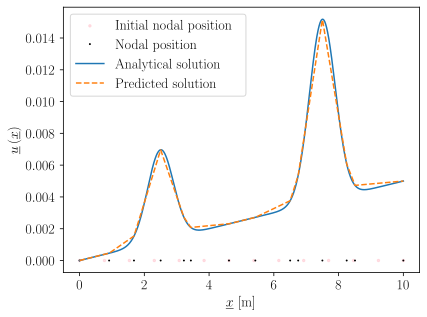

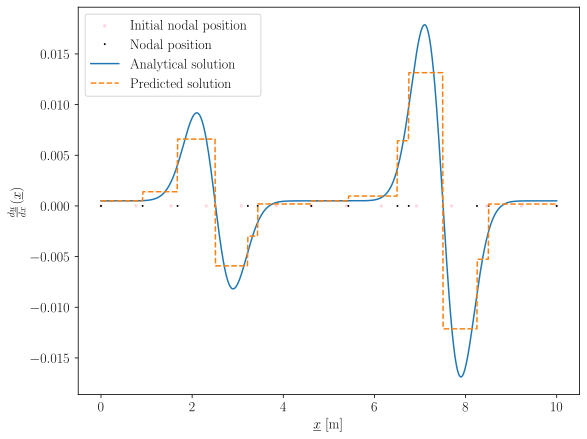

<Figure size 640x480 with 0 Axes>

In [4]:
    Pplot.Plot_Eval_1d(Model_FEM,config,Mat)
